In [52]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import snowflake.connector

In [57]:
# Connect to Snowflake
snowflake_connection = snowflake.connector.connect(
    user='SUSHMAMENGANI',
    password='Srinidhi7',
    account='elugxls-ox45694',
    warehouse='COMPUTE_WH',
    database='COVID19_EPIDEMIOLOGICAL_DATA',
    schema='public'
)


In [10]:
# Execute the SQL query and fetch the data
sql_query = """
SELECT
  agegroup,
  SUM(deaths) as total_deaths
FROM
  scs_be_detailed_mortality
WHERE
  deaths IS NOT NULL
  AND agegroup IS NOT NULL
GROUP BY
  agegroup;
"""


In [ ]:
df = pd.read_sql_query(sql_query, snowflake_connection)


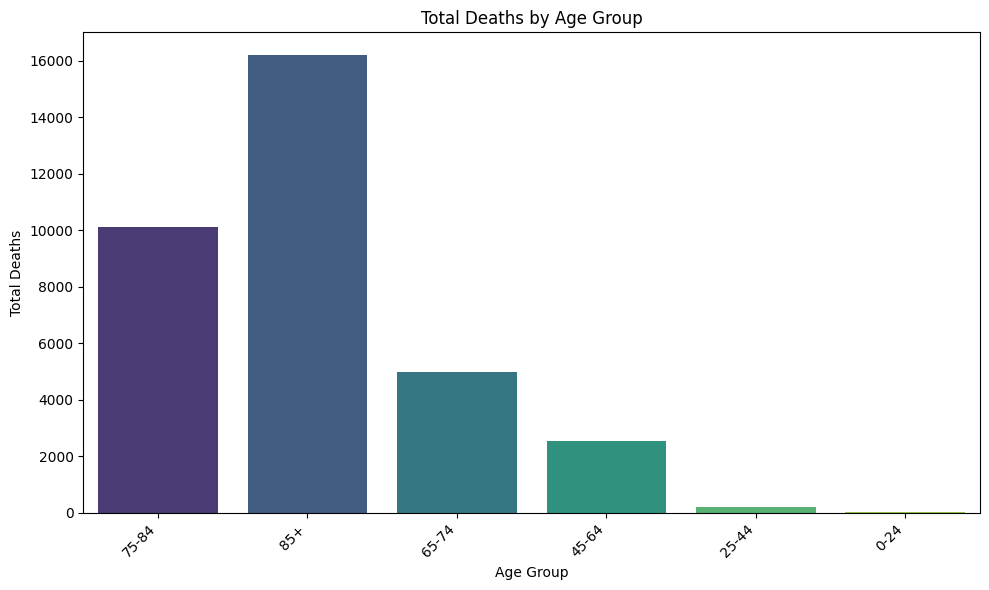

In [12]:
# Visualizing the data using seaborn and matplotlib
# This visualization shows Deaths of people by Age Group:

plt.figure(figsize=(10, 6))

# Bar plot for total deaths by age group
sns.barplot(x='AGEGROUP', y='TOTAL_DEATHS', data=df, palette='viridis', hue='AGEGROUP', legend=False)

plt.title('Total Deaths by Age Group')
plt.xlabel('Age Group')
plt.ylabel('Total Deaths')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
plt.tight_layout()
plt.show()


In [92]:
# Execute the SQL query and fetch the data
sql_query = """
SELECT
  country_region,
  cases,
  deaths,
  date,
  CASE WHEN cases > 0 THEN (deaths / cases) * 100 ELSE NULL END AS Death_Percentage
FROM
  ecdc_global
WHERE
  country_region LIKE '%Austria'
  AND continentexp IS NOT NULL
  AND cases > 0 
  AND deaths > 0;
"""

In [ ]:

df = pd.read_sql_query(sql_query, snowflake_connection)

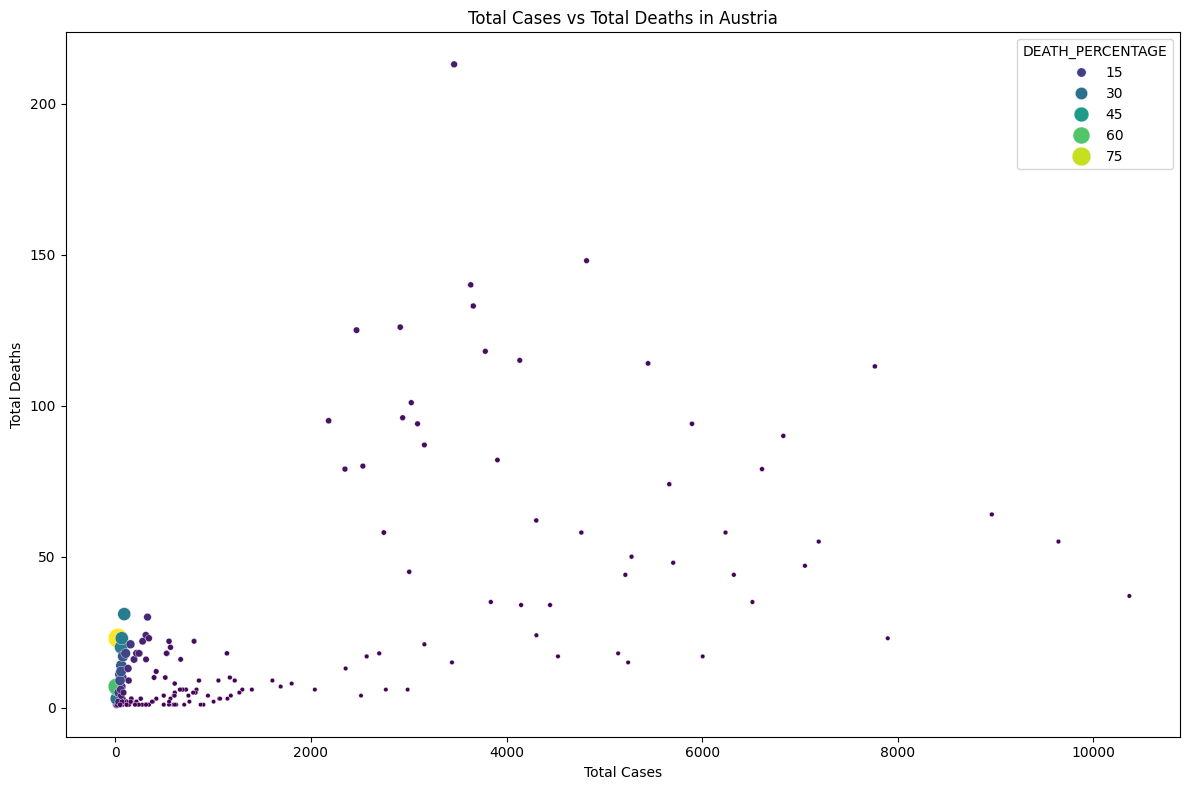

In [10]:

# This visualization shows the Total cases vs Total Detahs in Austria
plt.figure(figsize=(12, 8))
sns.scatterplot(x='CASES', y='DEATHS', data=df, hue='DEATH_PERCENTAGE', size='DEATH_PERCENTAGE', palette='viridis', sizes=(10, 200))
plt.title('Total Cases vs Total Deaths in Austria')
plt.xlabel('Total Cases')
plt.ylabel('Total Deaths')
plt.tight_layout()
plt.show()


In [6]:
 # Execute the SQL query and fetch the data
sql_query = """
SELECT
  country_region,
  date,
  population,
  cases,
  -- Using NULLIF to avoid division by zero
  (cases / NULLIF(population, 0)) * 100 as Percent_Population_Infected
FROM
  ecdc_global
WHERE
  cases > 0;
"""

In [ ]:

df = pd.read_sql_query(sql_query, snowflake_connection)


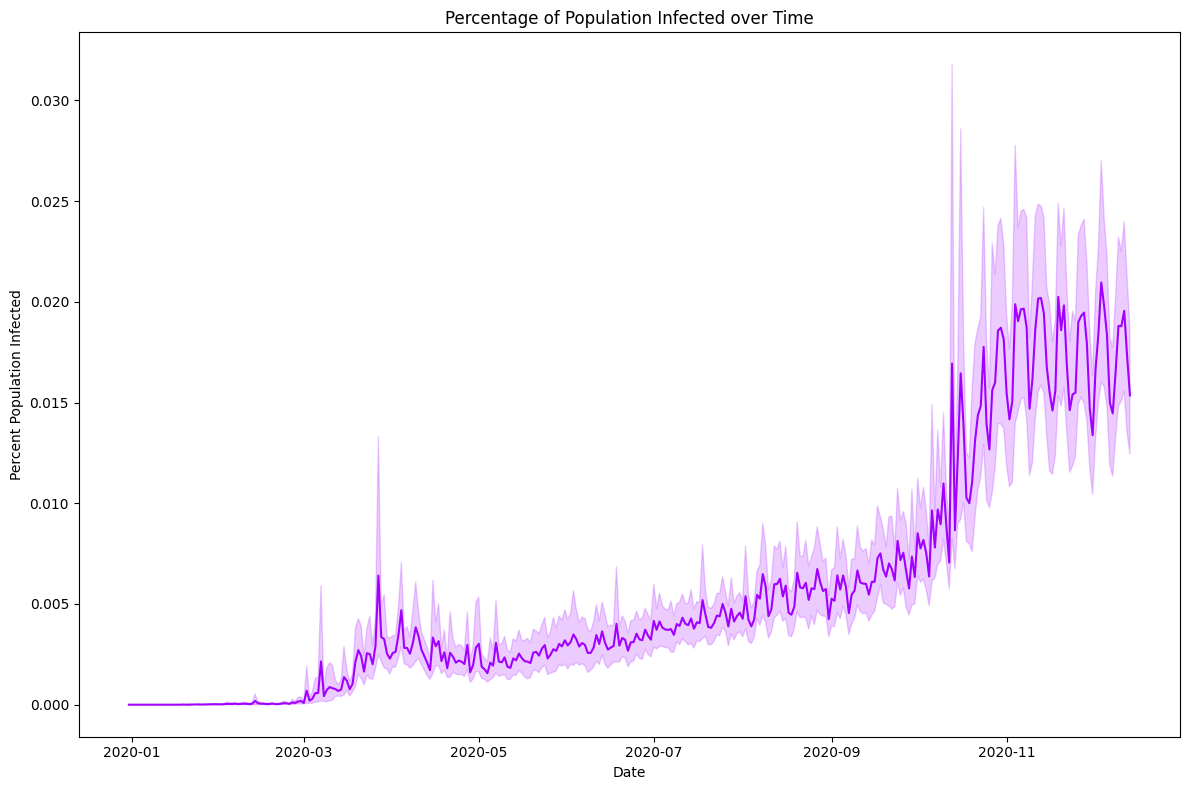

In [8]:
plt.figure(figsize=(12, 8))

# Line plot for percentage of population infected
sns.lineplot(x='DATE', y='PERCENT_POPULATION_INFECTED', data=df, color='#A100FF') 

plt.title('Percentage of Population Infected over Time')
plt.xlabel('Date')
plt.ylabel('Percent Population Infected')
plt.tight_layout()
plt.show()



In [13]:

# Execute the SQL query and fetch the data
sql_query = """
SELECT
  date,
  SUM(deaths) as total_deaths,
  SUM(cases) as total_cases,
  -- Using NULLIF to avoid division by zero
  (SUM(deaths) / NULLIF(SUM(cases), 0)) * 100 as mortality_rate
FROM
  ecdc_global
WHERE
  continentexp IS NOT NULL
GROUP BY
  date
HAVING
  SUM(cases) > 0 AND
  SUM(deaths) > 0 
ORDER BY
  date;
"""


In [ ]:
df = pd.read_sql_query(sql_query, snowflake_connection)

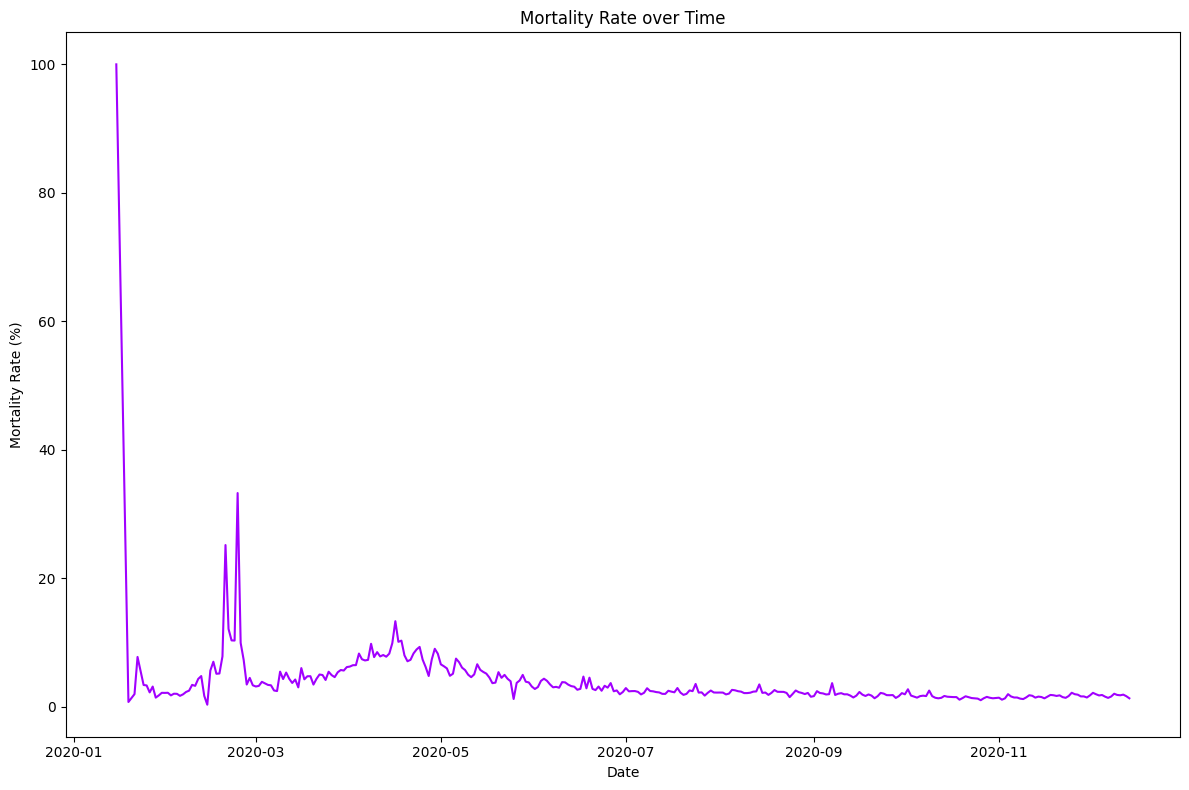

In [15]:
#Shows how the percentage of deaths relative to cases changes over different dates. 
# Useful for tracking the impact of COVID-19 and allocating healthcare resources
plt.figure(figsize=(12, 8))

# Line plot for mortality rate over time
sns.lineplot(x='DATE', y='MORTALITY_RATE', data=df, color='#A100FF')

plt.title('Mortality Rate over Time')
plt.xlabel('Date')
plt.ylabel('Mortality Rate (%)')
plt.tight_layout()
plt.show()



In [16]:
# Execute the SQL query and fetch the data
sql_query = """
SELECT
  country_region,
  SUM(deaths) as total_deaths,
  SUM(cases) as total_cases,
  (SUM(deaths) / NULLIF(SUM(cases), 0)) * 100 as mortality_rate
FROM
  ecdc_global
WHERE
  continentexp IS NOT NULL
GROUP BY
  country_region
ORDER BY
  mortality_rate DESC
LIMIT 5;
"""

In [ ]:
df_top5 = pd.read_sql_query(sql_query, snowflake_connection)

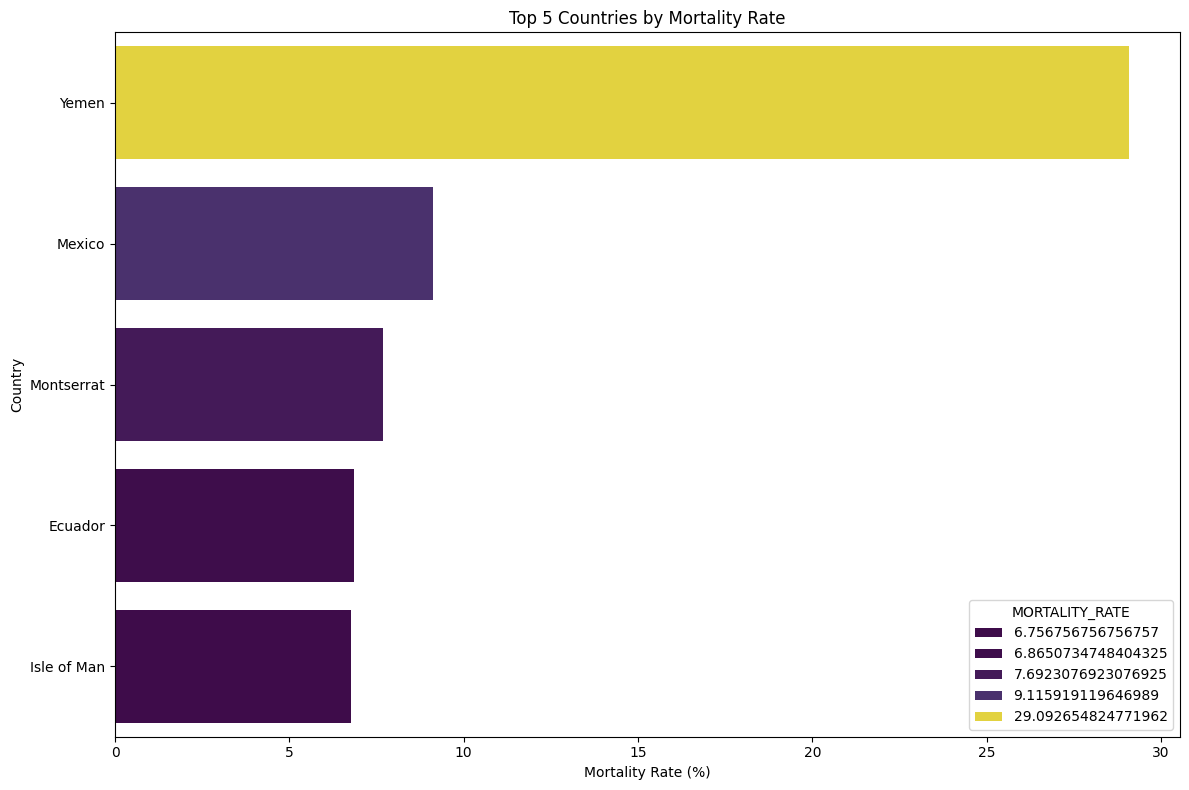

In [22]:
# Visualization: Top 5 Countries by Mortality Rate
plt.figure(figsize=(12, 8))

# Bar plot for top 5 countries by mortality rate
sns.barplot(x='MORTALITY_RATE', y='COUNTRY_REGION', data=df_top5, hue='MORTALITY_RATE', palette='viridis', dodge=False)

plt.title('Top 5 Countries by Mortality Rate')
plt.xlabel('Mortality Rate (%)')
plt.ylabel('Country')
plt.tight_layout()
plt.show()



In [29]:
# Execute the SQL query and fetch the data
sql_query = """
SELECT
  dea.country_region,
  dea.continentexp,
  dea.date,
  dea.population,
  vac.people_vaccinated,
  vac.people_fully_vaccinated,
  COALESCE(vac.people_vaccinated, 0) as people_vaccinated_nonull,
  COALESCE(vac.people_fully_vaccinated, 0) as people_fully_vaccinated_nonull,
  (COALESCE(vac.people_vaccinated, 0) + COALESCE(vac.people_fully_vaccinated, 0)) as total_vaccinated,
  (total_vaccinated / NULLIF(dea.population, 0)) * 100 as PercentPopulationVaccinated
FROM
  ecdc_global dea
JOIN
  OWID_VACCINATIONS vac
  ON dea.country_region = vac.country_region
  AND dea.date = vac.date
WHERE
  dea.country_region IS NOT NULL;
"""


In [ ]:
df_vaccination_population = pd.read_sql_query(sql_query, snowflake_connection)


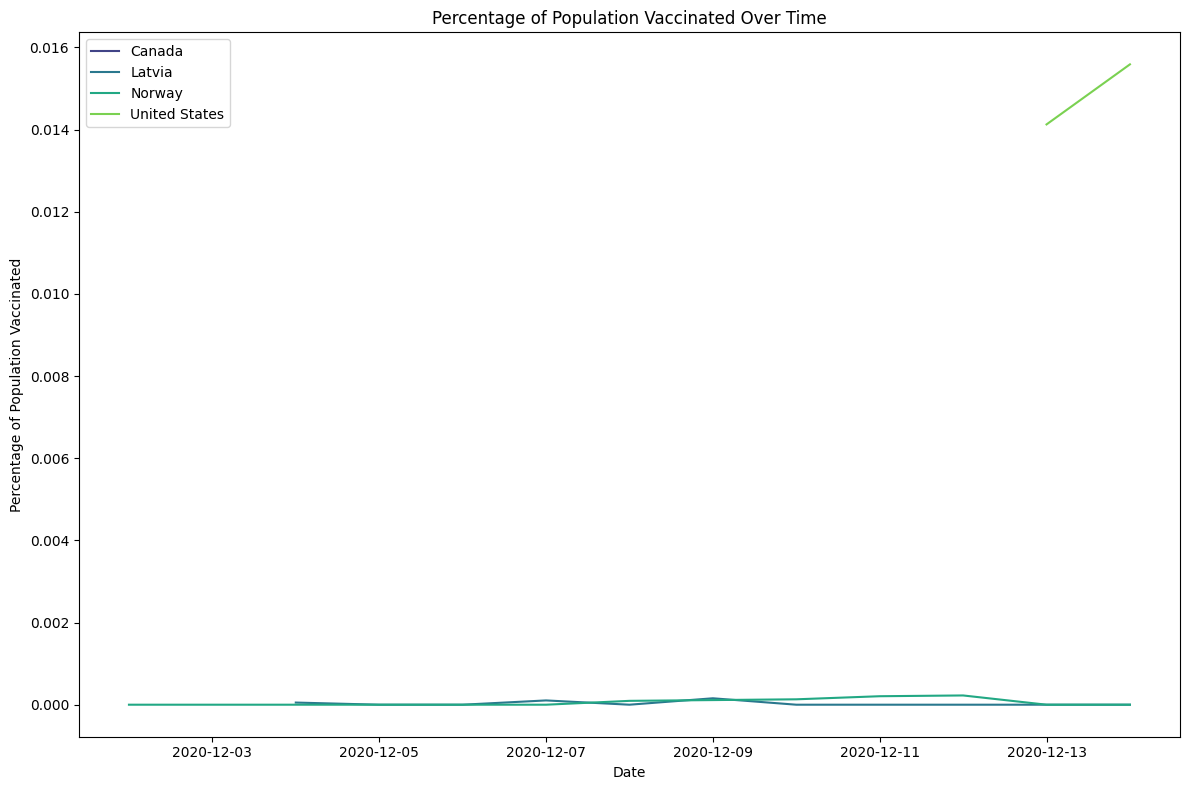

In [31]:
# Shows Percentage of Population that has received at least one Covid Vaccine
plt.figure(figsize=(12, 8))

# Line plot for percentage of population vaccinated
sns.lineplot(x='DATE', y='PERCENTPOPULATIONVACCINATED', hue='COUNTRY_REGION', data=df_vaccination_population, palette='viridis')

plt.title('Percentage of Population Vaccinated Over Time')
plt.xlabel('Date')
plt.ylabel('Percentage of Population Vaccinated')
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()

In [34]:

# Execute the SQL query and fetch the data
sql_query = """
SELECT
  DATE,
  COUNTRY_REGION,
  PROVINCE_STATE,
  GROCERY_AND_PHARMACY_CHANGE_PERC,
  PARKS_CHANGE_PERC,
  RESIDENTIAL_CHANGE_PERC,
  RETAIL_AND_RECREATION_CHANGE_PERC,
  TRANSIT_STATIONS_CHANGE_PERC,
  WORKPLACES_CHANGE_PERC
FROM
  GOOG_GLOBAL_MOBILITY_REPORT
WHERE
  COUNTRY_REGION = 'United States'
  AND PROVINCE_STATE = 'Virginia'
  AND SUB_REGION_2 = 'Alexandria';
"""


In [ ]:
df_mobility = pd.read_sql_query(sql_query, snowflake_connection)

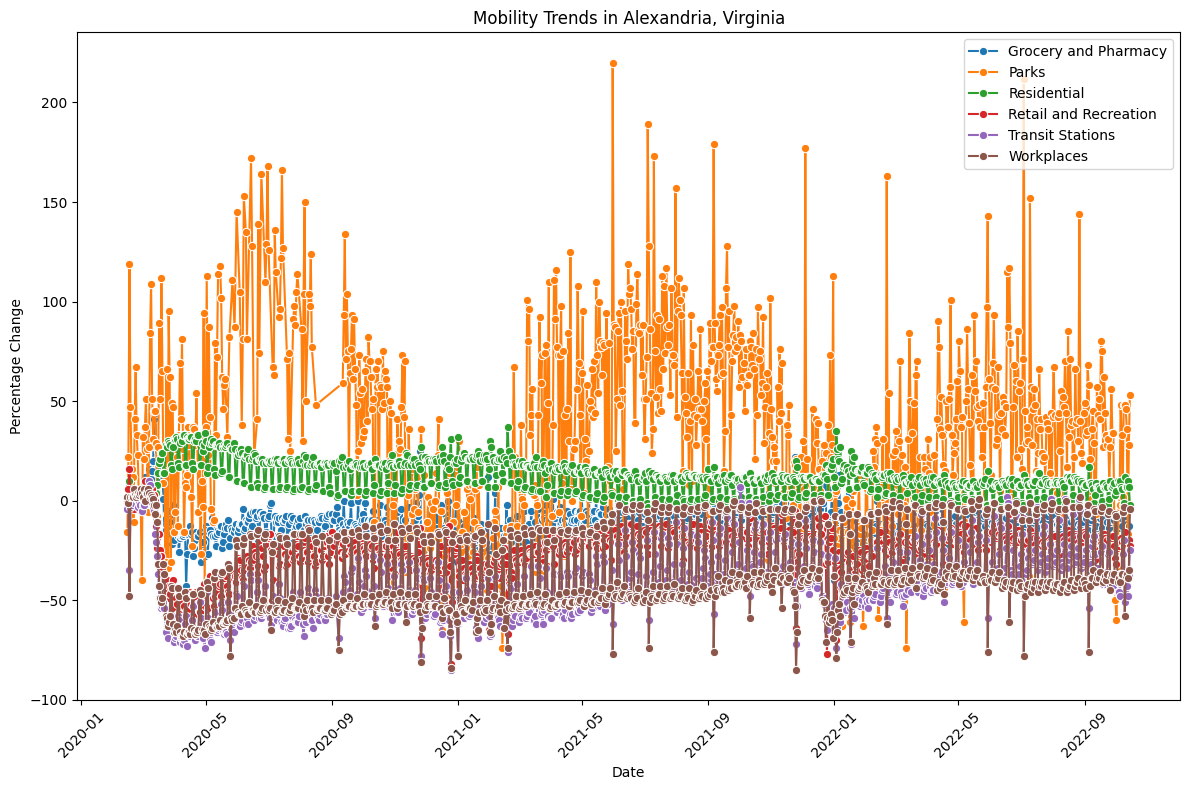

In [36]:

# Visualization: Mobility Trends in Alexandria, Virginia
plt.figure(figsize=(12, 8))
sns.lineplot(x='DATE', y='GROCERY_AND_PHARMACY_CHANGE_PERC', data=df_mobility, label='Grocery and Pharmacy', marker='o')
sns.lineplot(x='DATE', y='PARKS_CHANGE_PERC', data=df_mobility, label='Parks', marker='o')
sns.lineplot(x='DATE', y='RESIDENTIAL_CHANGE_PERC', data=df_mobility, label='Residential', marker='o')
sns.lineplot(x='DATE', y='RETAIL_AND_RECREATION_CHANGE_PERC', data=df_mobility, label='Retail and Recreation', marker='o')
sns.lineplot(x='DATE', y='TRANSIT_STATIONS_CHANGE_PERC', data=df_mobility, label='Transit Stations', marker='o')
sns.lineplot(x='DATE', y='WORKPLACES_CHANGE_PERC', data=df_mobility, label='Workplaces', marker='o')

plt.title('Mobility Trends in Alexandria, Virginia')
plt.xlabel('Date')
plt.ylabel('Percentage Change')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

In [16]:
# Execute the SQL query and fetch the data
sql_query = """
SELECT
  c.COUNTRY,
  c.GDPCAP,
  c.DATE
FROM economic_data.public.global_economy c
LEFT JOIN kff_us_state_mitigations r
ON c.COUNTRY = r.COUNTRY_REGION
AND c.DATE >= r.LAST_UPDATED_DATE;
"""


In [ ]:
df_economic_data = pd.read_sql_query(sql_query, snowflake_connection)

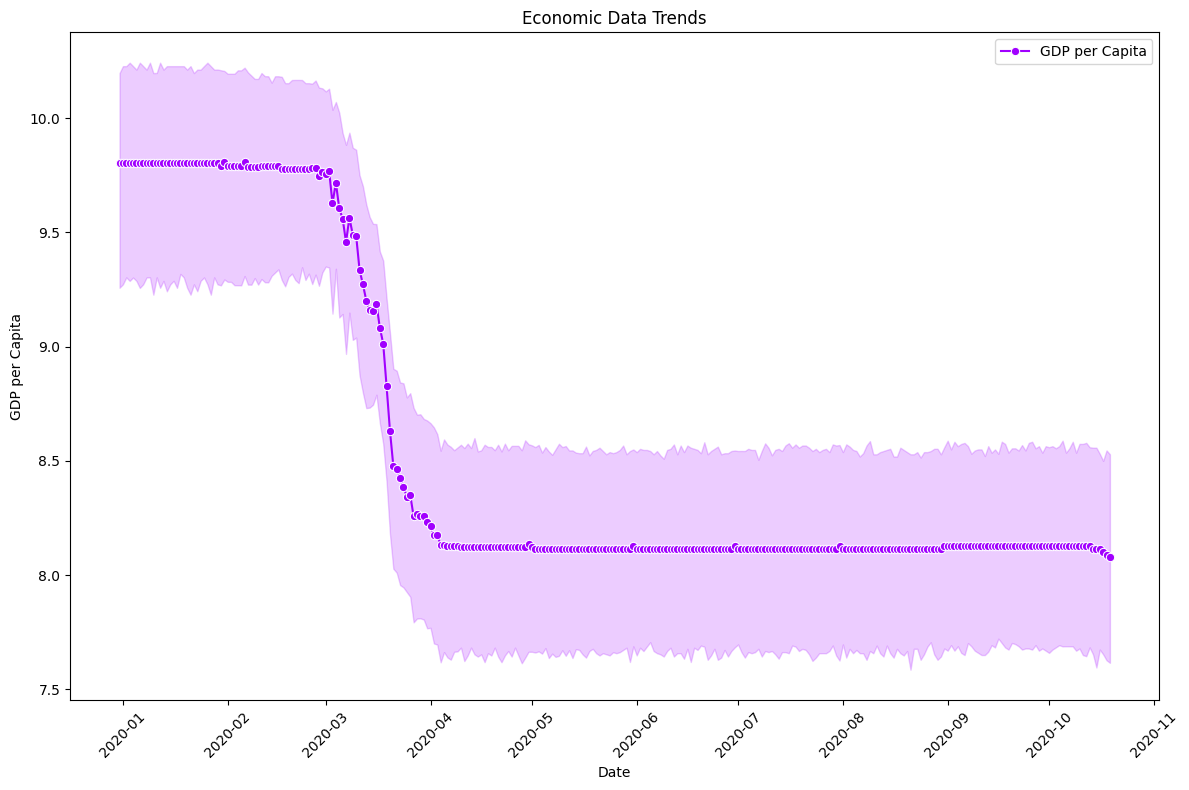

In [18]:
# Visualization: Economic Data Trends
plt.figure(figsize=(12, 8))
sns.lineplot(x='DATE', y='GDPCAP', data=df_economic_data, label='GDP per Capita', marker='o', color = '#A100FF')

plt.title('Economic Data Trends')
plt.xlabel('Date')
plt.ylabel('GDP per Capita')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

In [60]:
# Execute the SQL query and fetch the data
sql_query = """
SELECT
  date,
  country_region,
  total_vaccinations,
  people_vaccinated,
  people_fully_vaccinated
FROM
  owid_vaccinations
WHERE
  country_region IS NOT NULL
  AND people_vaccinated IS NOT NULL
  AND people_vaccinated > 0
  AND people_fully_vaccinated IS NOT NULL
  AND people_fully_vaccinated > 0
ORDER BY
  date;
"""

In [ ]:
df_vaccinations = pd.read_sql_query(sql_query, snowflake_connection)

/var/folders/v_/7904q47n6bn5nm7byff92ml40000gn/T/ipykernel_17148/3031810401.py:7: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.lineplot(x='DATE', y='TOTAL_VACCINATIONS', data=df_vaccinations, palette='viridis', label='Total Vaccinations')
/var/folders/v_/7904q47n6bn5nm7byff92ml40000gn/T/ipykernel_17148/3031810401.py:10: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.lineplot(x='DATE', y='PEOPLE_VACCINATED', data=df_vaccinations, palette='viridis', label='People Vaccinated')
/var/folders/v_/7904q47n6bn5nm7byff92ml40000gn/T/ipykernel_17148/3031810401.py:13: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.lineplot(x='DATE', y='PEOPLE_FULLY_VACCINATED', data=df_vaccinations, palette='viridis', label='People Fully Vaccinated')


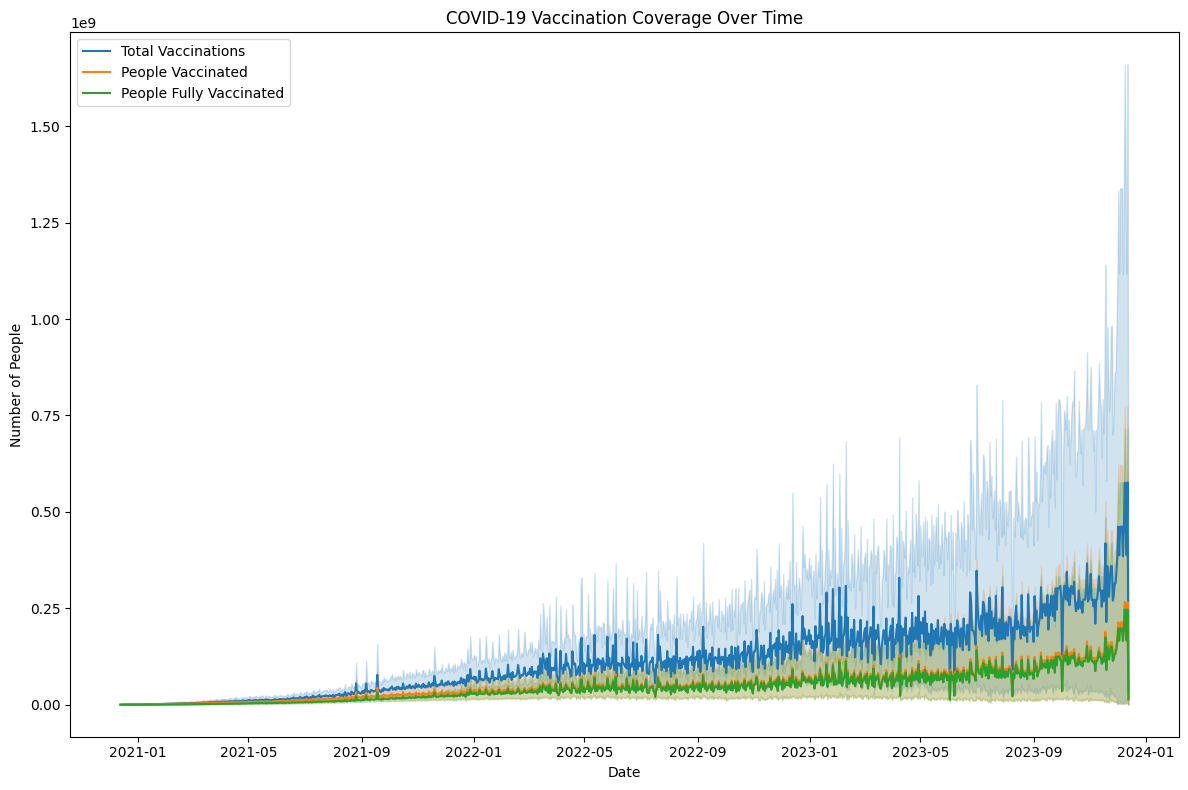

In [62]:
#Shows the progress of COVID-19 vaccination by tracking the number of people partially and fully vaccinated over time.
# Useful for monitoring vaccination efforts and understanding the coverage in different countries.

plt.figure(figsize=(12, 8))

# Line plot for total vaccinations
sns.lineplot(x='DATE', y='TOTAL_VACCINATIONS', data=df_vaccinations, palette='viridis', label='Total Vaccinations')

# Line plot for people partially vaccinated
sns.lineplot(x='DATE', y='PEOPLE_VACCINATED', data=df_vaccinations, palette='viridis', label='People Vaccinated')

# Line plot for people fully vaccinated
sns.lineplot(x='DATE', y='PEOPLE_FULLY_VACCINATED', data=df_vaccinations, palette='viridis', label='People Fully Vaccinated')

plt.title('COVID-19 Vaccination Coverage Over Time')
plt.xlabel('Date')
plt.ylabel('Number of People')
plt.legend(loc='upper left') 
plt.tight_layout()
plt.show()
# kindly ignore the warnings